In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay


In [2]:
# Load cleaned dataset
df = pd.read_csv("../data/cleaned_churn_data.csv")

# Feature & target
X = df.drop("Exited", axis=1)
y = df["Exited"]

categorical_cols = ['Geography', 'Gender']
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                  'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss", random_state=42
    ),
    "SVM": SVC(probability=True)
}

# Fit each model once and store fitted pipelines
fitted_pipelines = {}
results = []

for name, model in models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    fitted_pipelines[name] = pipe

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC Score": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).sort_values(by="AUC Score", ascending=False)
print("\nFinal Model Comparison:\n", results_df)


Final Model Comparison:
                  Model  Accuracy  Precision    Recall  F1 Score  AUC Score
2              XGBoost     0.881   0.821429  0.550239  0.659026   0.873221
1        Random Forest     0.873   0.836066  0.488038  0.616314   0.857107
3                  SVM     0.861   0.864583  0.397129  0.544262   0.843545
0  Logistic Regression     0.816   0.671233  0.234450  0.347518   0.782620


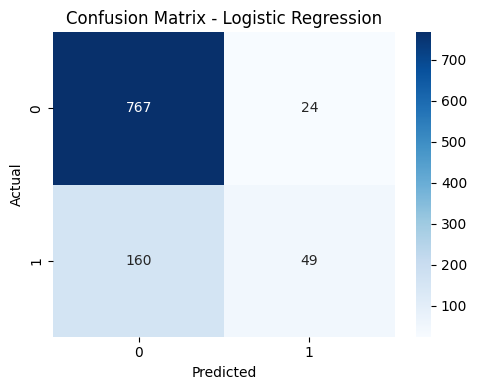

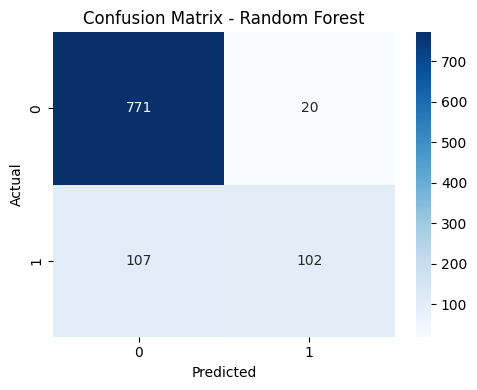

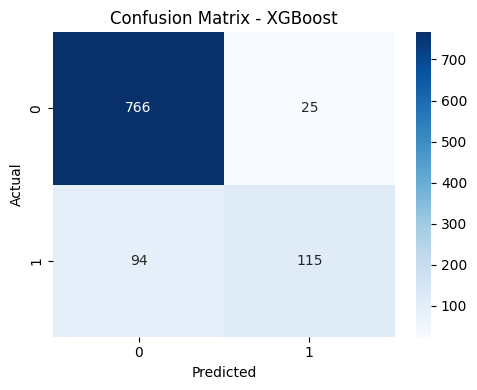

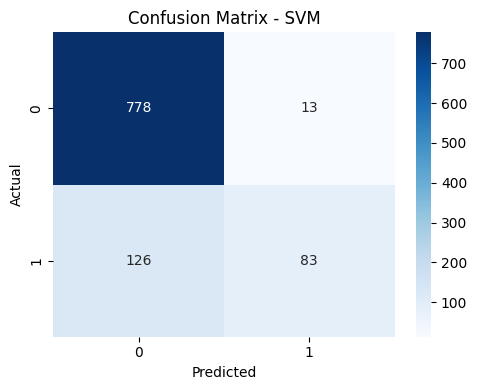

In [4]:
# Plot confusion matrices 

for name, pipe in fitted_pipelines.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

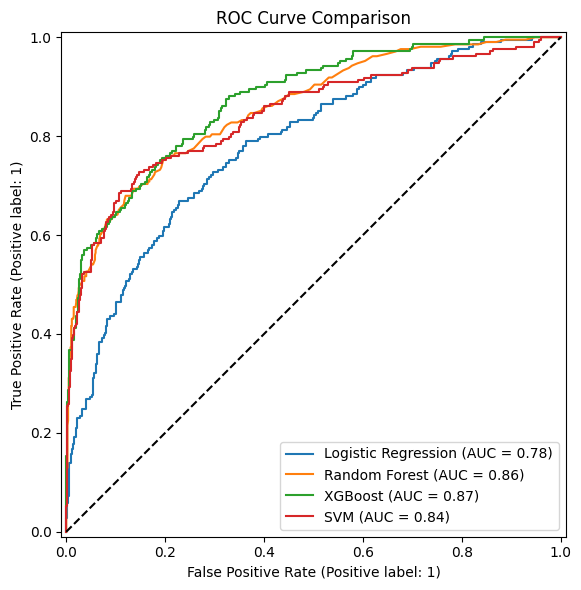

In [5]:
# ROC comparison (single figure)
fig, ax = plt.subplots(figsize=(8,6))
for name, pipe in fitted_pipelines.items():
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name, ax=ax)
ax.plot([0,1], [0,1], 'k--')
ax.set_title("ROC Curve Comparison")
plt.tight_layout()
plt.show()
plt.close(fig)


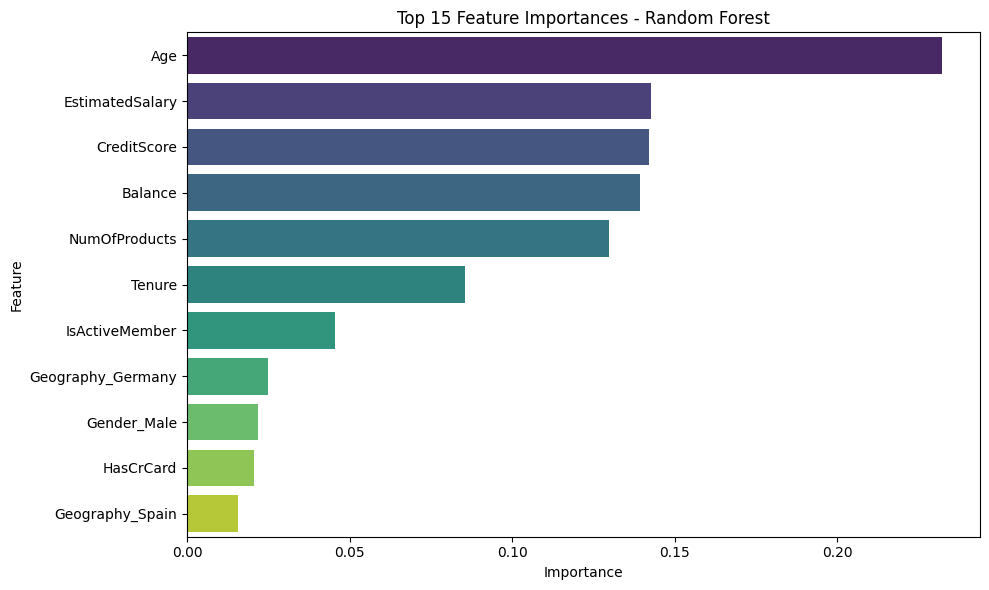

In [6]:
# Feature importance from Random Forest (use fitted Random Forest pipeline)
rf_pipe = fitted_pipelines["Random Forest"]

# Extract OHE feature names
ohe = rf_pipe.named_steps['preprocess'].transformers_[1][1]  # OneHotEncoder instance
ohe_feature_names = list(ohe.get_feature_names_out(categorical_cols))
all_features = numerical_cols + ohe_feature_names

importances = rf_pipe.named_steps['model'].feature_importances_
fi_df = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=fi_df.head(15), x='Importance', y='Feature', ax=ax, palette='viridis', hue='Feature')
ax.set_title("Top 15 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()
plt.close(fig)

In [7]:
# Save best model (based on AUC)
best_model_name = results_df.iloc[0]["Model"]
best_pipeline = fitted_pipelines[best_model_name]
joblib.dump(best_pipeline, "../models/final_churn_model.pkl")


['../models/final_churn_model.pkl']